## Company Bankruptcy Prediction

## Table of Contents

<ul>
    <li><a href='#intro'>Introduction</a></li>
    <li><a href='#wrangle'>Data Wrangling</a></li>
    <li><a href='#ml'>Machine Learning</a></li>
    <li><a href='#conclusion'>Conclusion</a></li>
</ul>

<a id='intro'></a>
## Introduction
The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. 

In this notebook, I built a LightGBM Classifier to predict company bankruptcy using financial performance. The model has accuracy 0.99 and F1-score 0.99. To report the prediction results, I used SHAP to explain the outcomes of this model. 

This model would help investors assess the performance and potential of companies based on the visualized prediction outcomes of machine learning model.

<a id='wrangle'></a>
## Data Wrangling

In [35]:
# Import packages

## general packages
import numpy as np
import pandas as pd

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
### Oversampling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
### LightGBM
import lightgbm as lgb
### Metrics
from sklearn.metrics import roc_auc_score, precision_score, classification_report
### Feature Selection
import shap

In [61]:
# Upload dataset
df = pd.read_csv('data.csv')
print(df.shape)
df.head(3)

(6819, 96)


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474


In [3]:
df2=df.copy()
df2['Bankrupt?'].replace({0:'No', 1: 'Yes'}, inplace=True)
df2.head(3)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,Yes,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,Yes,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,Yes,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474


In [4]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


There are 95 variables describing the condition of companies, plus one column "Bankrupt?" as the label.

The number of records is 6819.

Next, I'll check the existence of replicates and null values.

In [5]:
# check duplicates
df.duplicated().sum()

0

In [6]:
# check null values
df.isnull().any().any()

False

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

All features are numerical.

In [32]:
df['Bankrupt?'] = df['Bankrupt?'].astype('category')

### Class Balancing

In [33]:
labels = df['Bankrupt?'].value_counts()
labels.index=['No', 'Yes']
labels

No     6599
Yes     220
Name: Bankrupt?, dtype: int64

To solve the imbalance of labels, I used SMOTEENN method to oversample the minority class then clean the noisy samples.

In [9]:
ori_X = df.drop(['Bankrupt?'], axis=1)
ori_y = df['Bankrupt?']

smote_enn = SMOTEENN(random_state=28)
X, y = smote_enn.fit_resample(ori_X, ori_y)

The label distribution after SMOTEENN

In [10]:
new_labels = y.value_counts()
new_labels.index = ['No', 'Yes']
new_labels

No     6256
Yes    5426
Name: Bankrupt?, dtype: int64

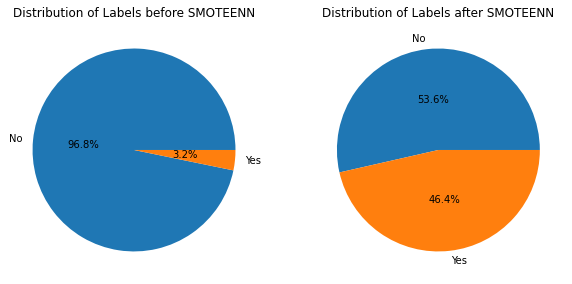

In [11]:
fig = plt.figure(figsize=[10, 6])
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.pie(labels, labels=labels.index, pctdistance=0.5, autopct='%.1f%%')
ax1.pie(new_labels, labels=new_labels.index, pctdistance=0.5, autopct='%.1f%%')

ax0.set_title('Distribution of Labels before SMOTEENN')
ax1.set_title('Distribution of Labels after SMOTEENN');

<a id='ml'></a>
## Machine Learning

### Modeling

Use Scikit-learn API:

In [12]:
# Split data into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

In [13]:
# Parameter tuning
params = {'boosting_type': ['gbdt'], # gradient boosted decision trees
          'objective': ['binary'],
          'metric': ['binary_logloss'],
          'max_bin': [128, 256, 512], 
          'num_leaves': [10, 20, 40],
          'max_depth': [5, 10, 15],
          'learning_rate': [0.01, 0.03, 0.1],# shrinkage factor
          'force_col_wise': [True]} # force col-wise histogram building when number of columns is large

In [14]:
lgb_est = lgb.LGBMClassifier()
gs = GridSearchCV(estimator=lgb_est, param_grid=params, cv=10)

In [15]:
lgbm = gs.fit(X_train, y_train)
print(lgbm.best_params_)

{'boosting_type': 'gbdt', 'force_col_wise': True, 'learning_rate': 0.1, 'max_bin': 128, 'metric': 'binary_logloss', 'num_leaves': 40, 'objective': 'binary'}


In [16]:
lgbm_est = lgb.LGBMClassifier(**lgbm.best_params_)
lgbm_est.fit(X_train, y_train)

LGBMClassifier(force_col_wise=True, max_bin=128, metric='binary_logloss',
               num_leaves=40, objective='binary')

Save the trained estimator

In [17]:
import dill
with open('lgbm_est', 'wb') as f:
    dill.dump(lgbm_est, f)

In [18]:
with open('lgbm_est', 'rb') as f:
    lgbm_est = dill.load(f)

In [19]:
y_pred = lgbm_est.predict(X_test)

In [20]:
roc_auc_score(y_pred, y_test)

0.9902133584825209

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1071
           1       0.98      1.00      0.99      1266

    accuracy                           0.99      2337
   macro avg       0.99      0.99      0.99      2337
weighted avg       0.99      0.99      0.99      2337



### Feature selection

In [22]:
# Load JS visualization code
shap.initjs()

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(lgbm_est)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [23]:
shap_values[1].shape

(9345, 95)

#### The total impact of features on the model

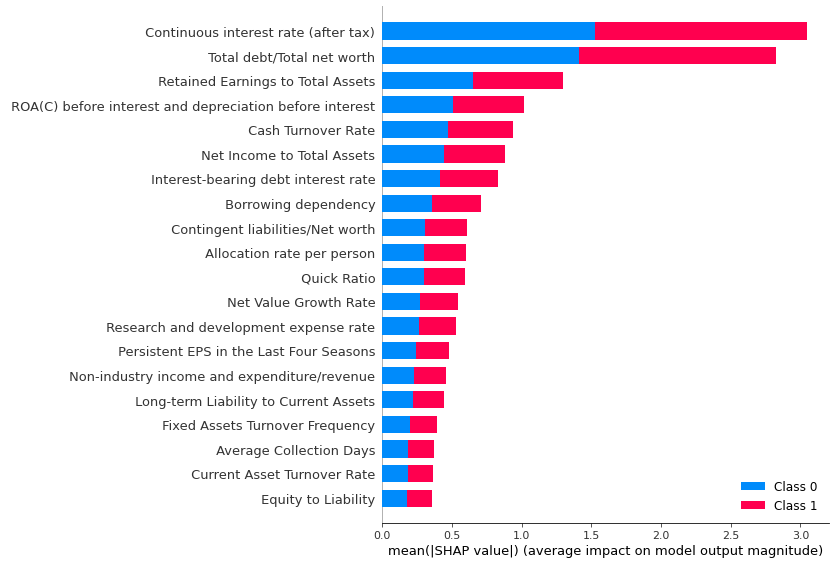

In [24]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar')

This plot shows the importance of features in a descending order. For example, the top feature "Continuous interest rate" contribute more to the model than the second feature "Total debt/total net worth". To figure out the relationships between features and prediction outcomes, I plotted the effect of these features on all records in the training data as shown below:

#### The impact of features on the model for individual data

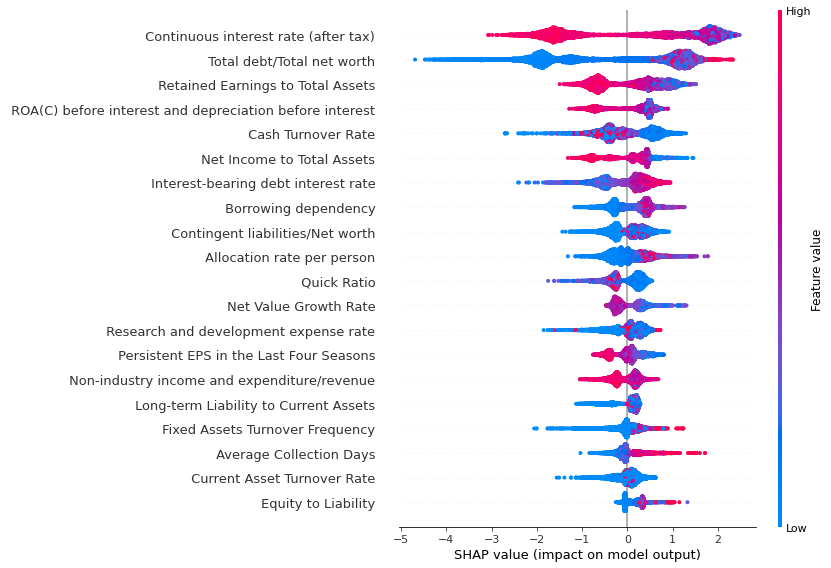

In [26]:
shap.summary_plot(shap_values[1], features=X_train, feature_names=X_train.columns)

This plot shows the positive and negative relationships of the features with the label. Similarly, features are ranked in descending order. Each dot represents one record in the training data. The color represents the value of the feature (red high, blue low). The horizontal axis represents the effect of feature on model prediction. For example, high continuous interest rate lowers the probability that model predict bankrupt. There is a negative relationship between continuous interest rate with bankrupt.

The dataframe of the features with corresponding shap values in descending order:

In [46]:
vals = np.abs(shap_values).mean(0) # calculate the shap values per row (feature)
feature_importance = pd.DataFrame(list(zip(X_train.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(10)

,col_name,feature_importance_vals
9,Continuous interest rate (after tax),14254.529148
35,Total debt/Total net worth,13212.092992
67,Retained Earnings to Total Assets,6052.262781
0,ROA(C) before interest and depreciation befor...,4761.351085
73,Cash Turnover Rate,4380.876959
85,Net Income to Total Assets,4129.024413
13,Interest-bearing debt interest rate,3872.185500
39,Borrowing dependency,3317.571305
40,Contingent liabilities/Net worth,2846.502203
52,Allocation rate per person,2793.641374


Visualize the relationships among these features 

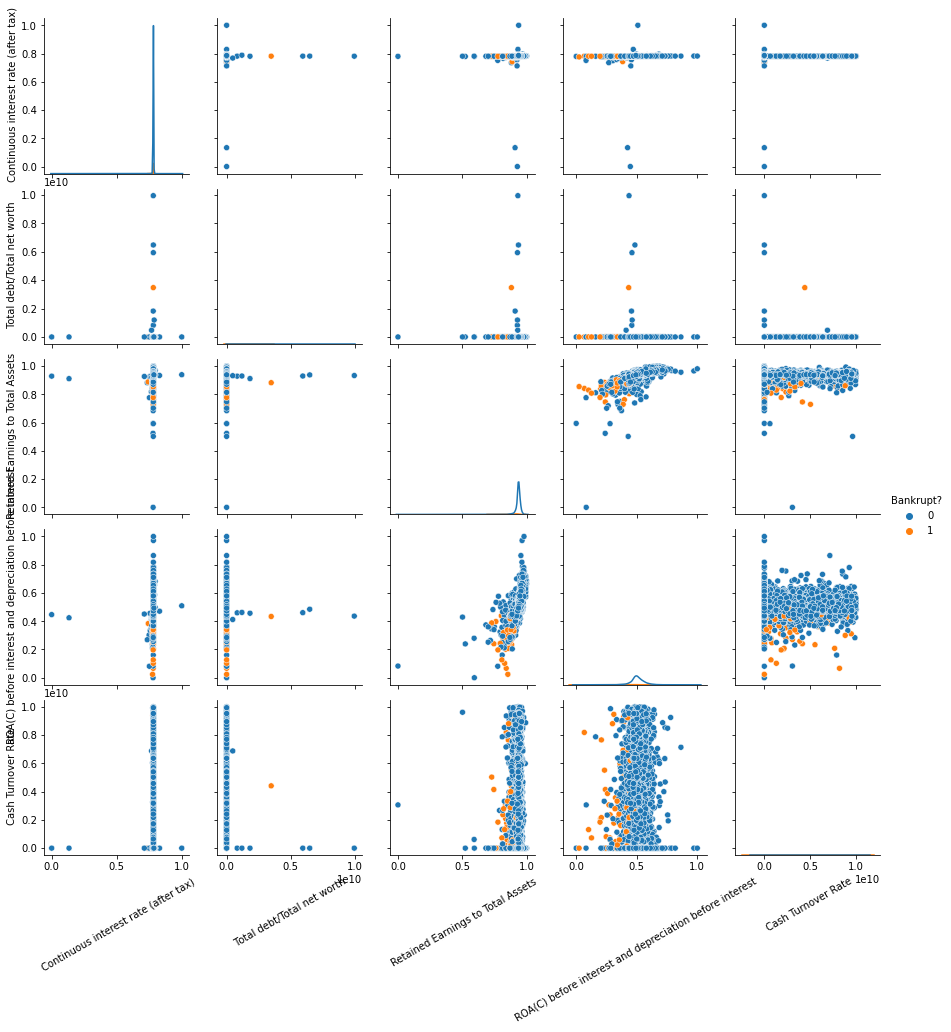

In [66]:
top_5 = feature_importance['col_name'][:5].to_list()
top_5.append('Bankrupt?')
g = sns.PairGrid(df[top_5], hue = "Bankrupt?")
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.scatterplot)
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation = 30)
g.add_legend();

#### The effect of a single feature across the whole dataset

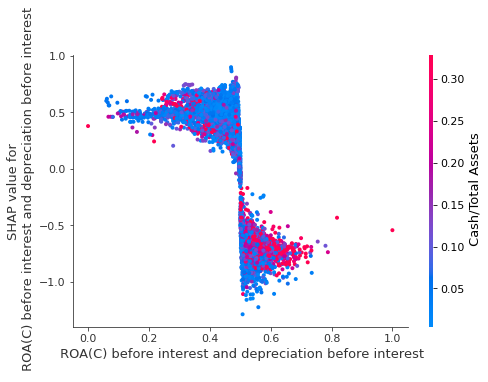

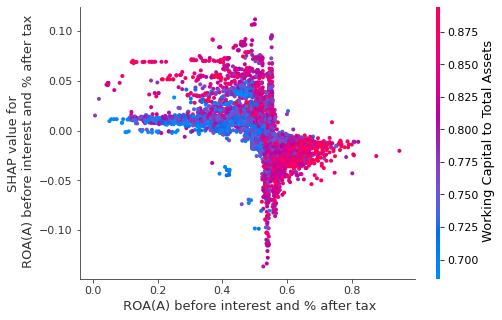

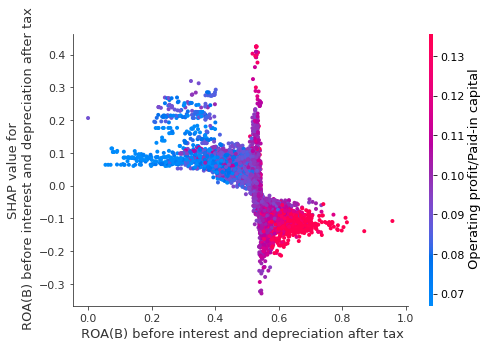

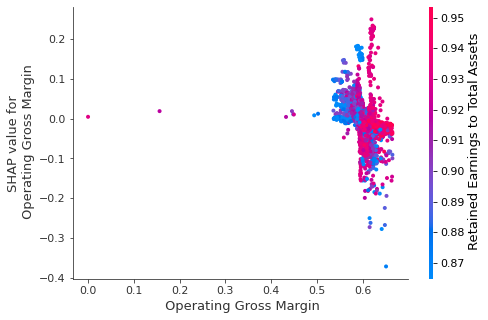

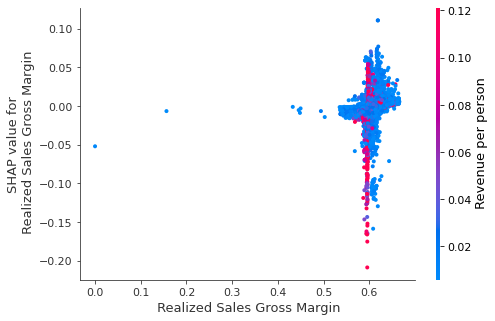

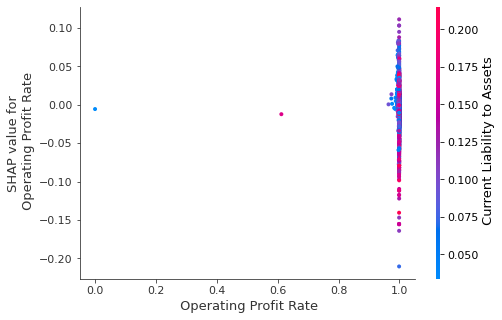

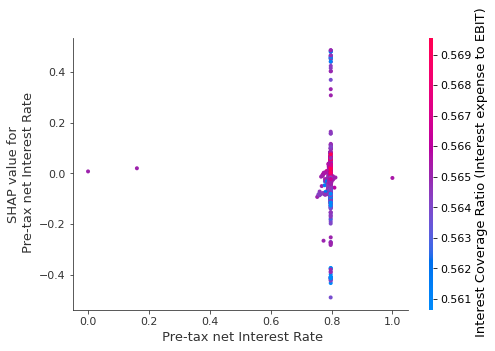

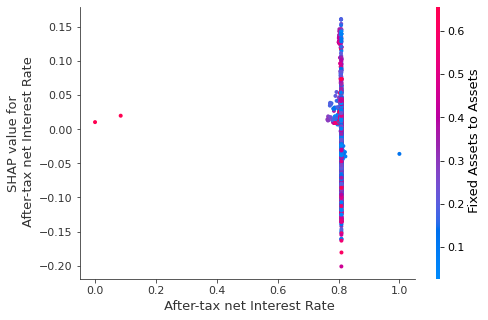

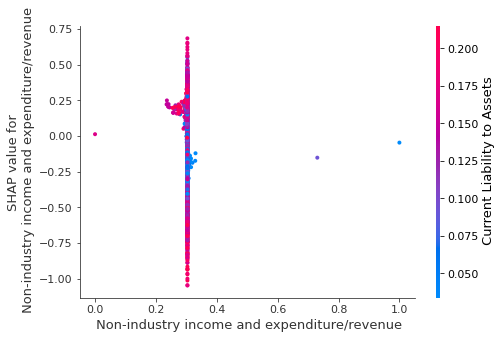

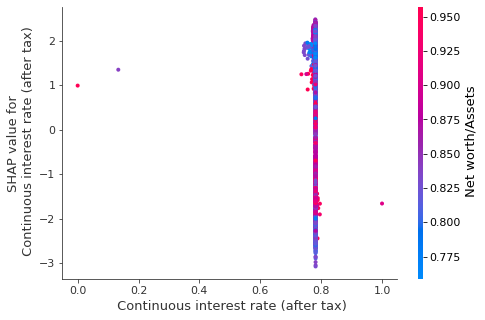

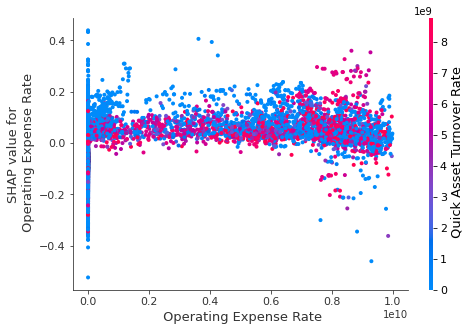

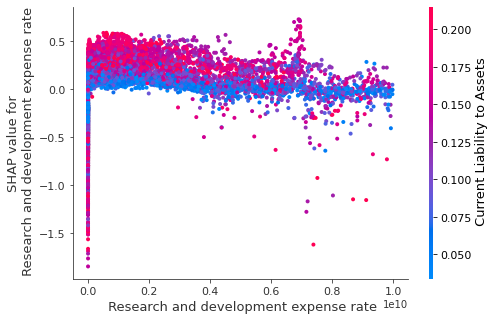

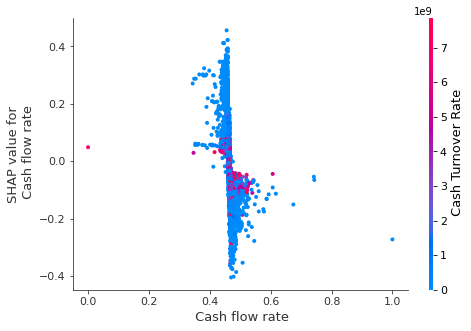

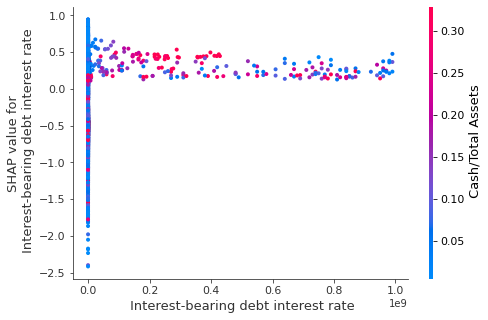

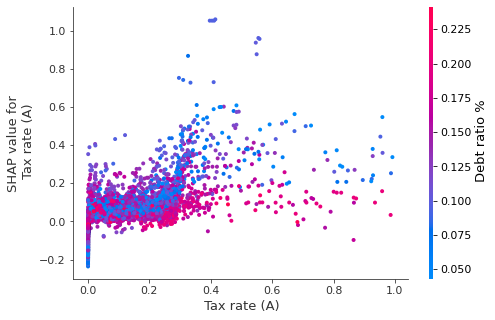

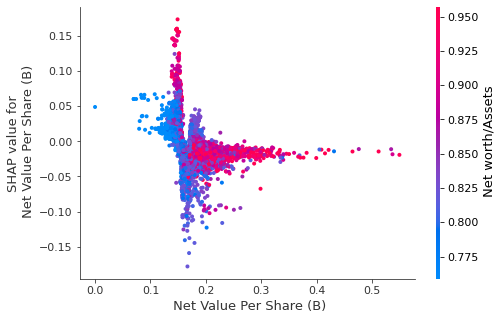

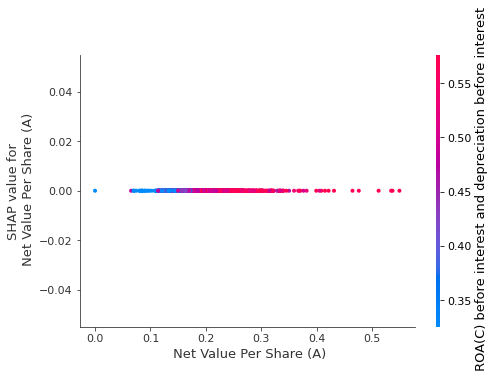

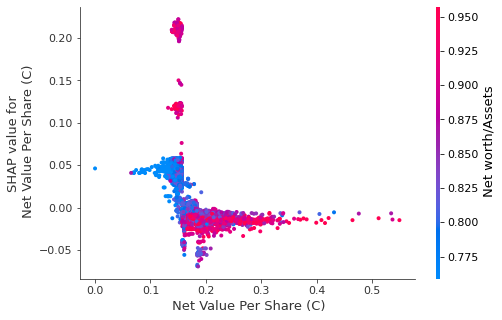

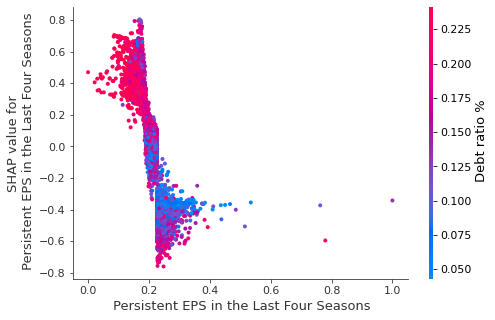

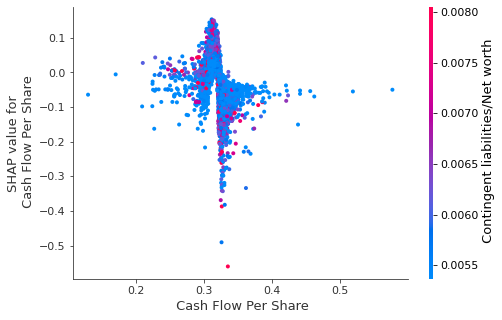

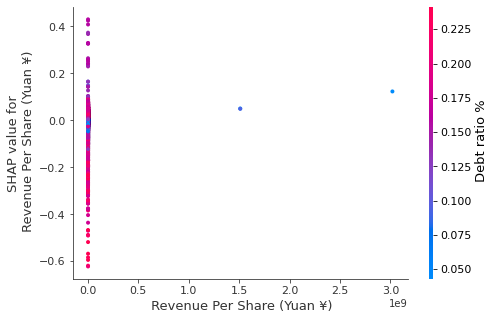

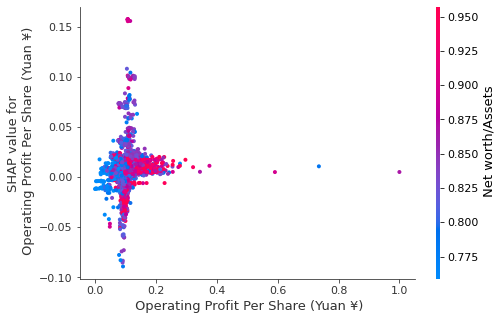

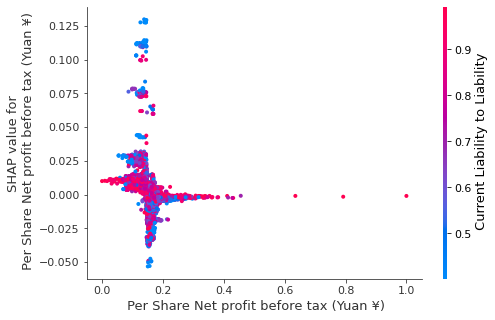

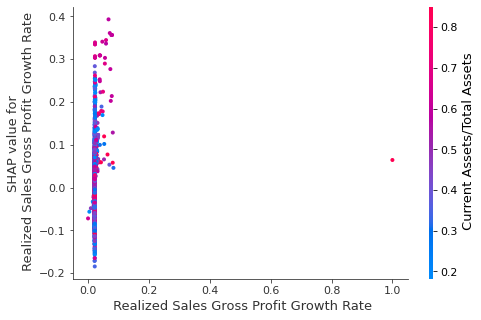

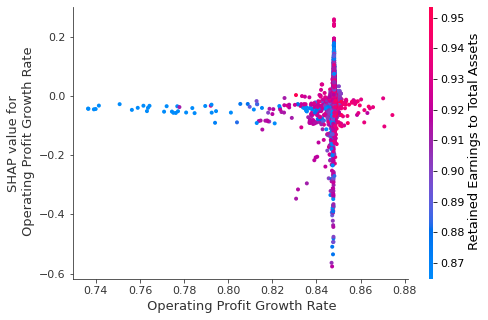

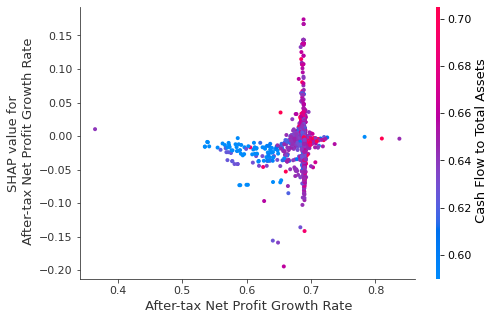

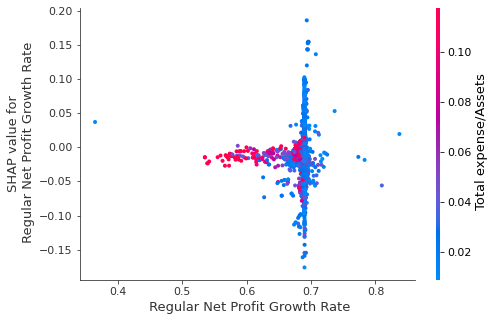

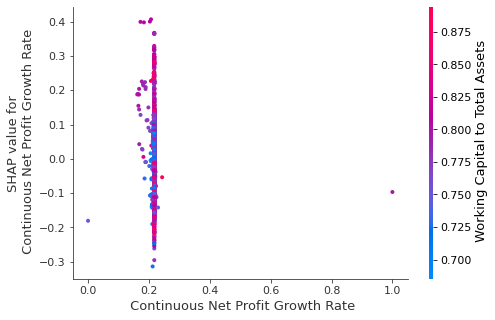

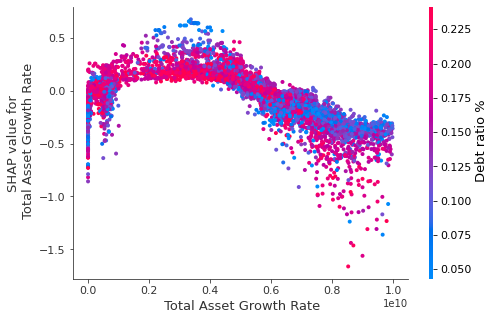

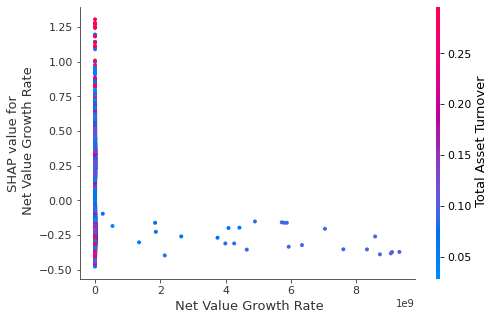

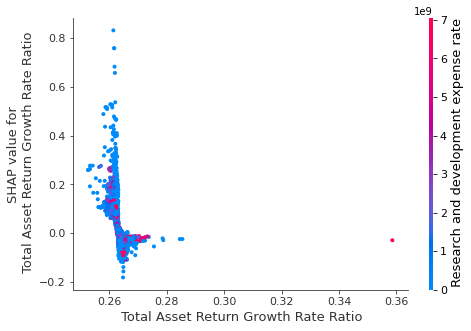

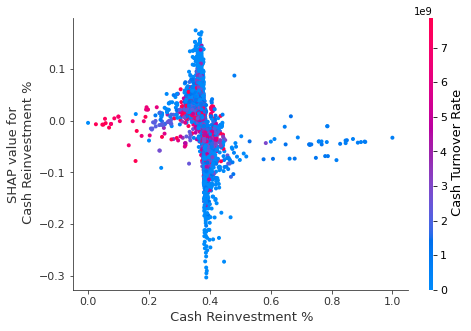

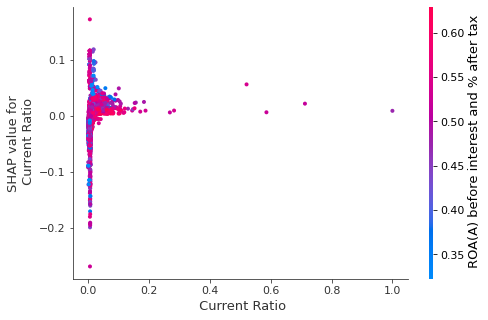

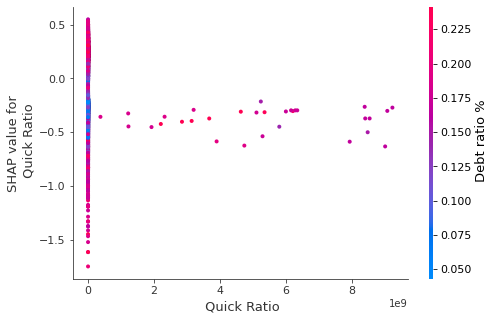

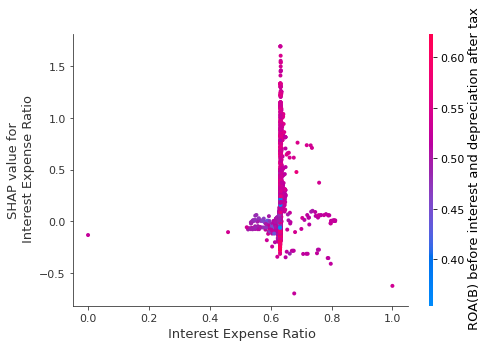

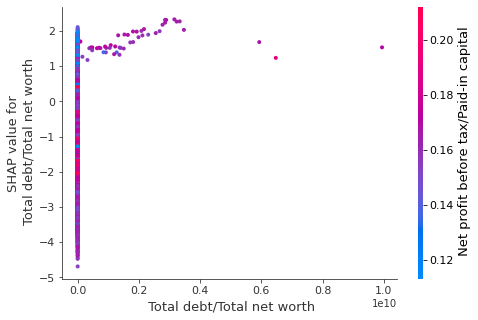

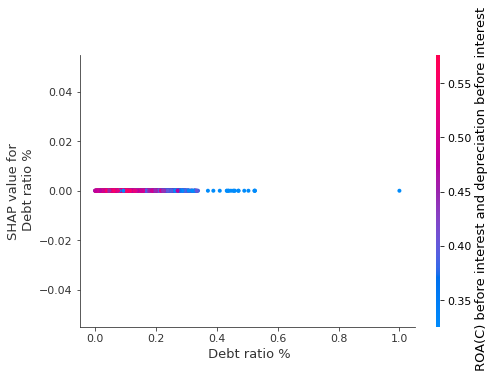

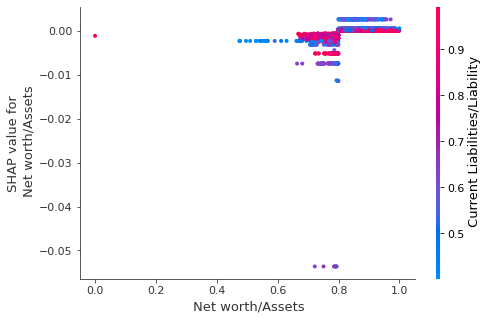

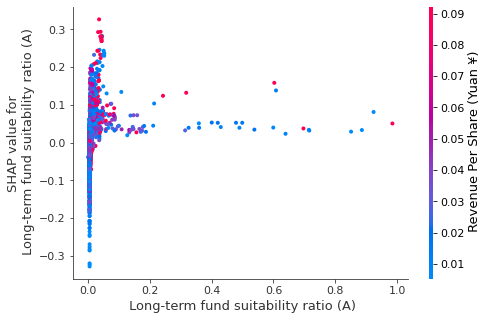

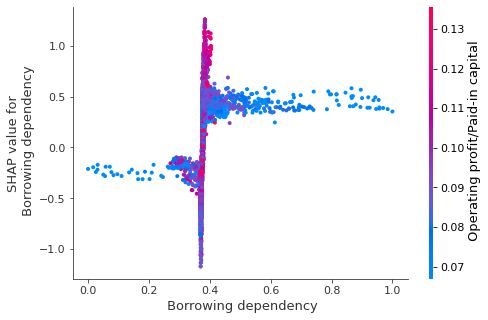

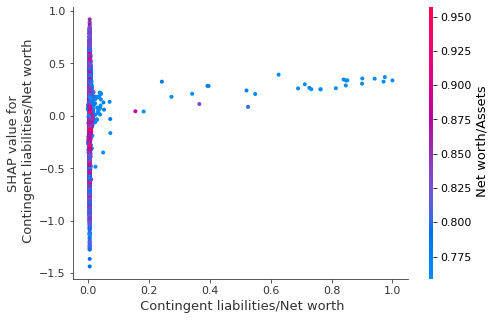

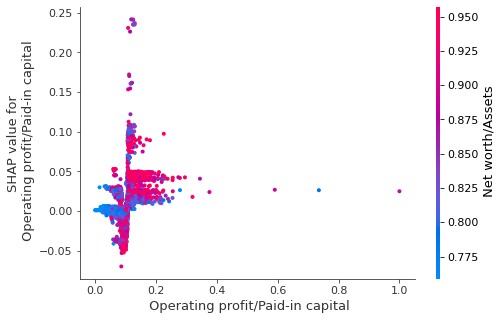

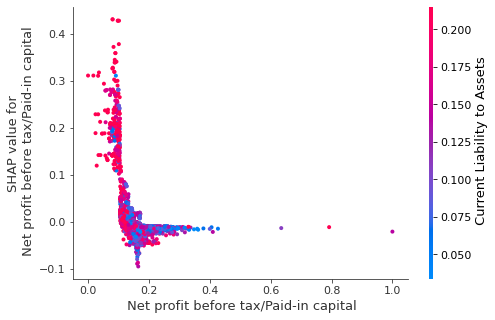

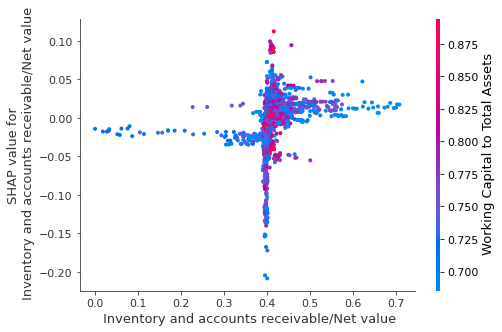

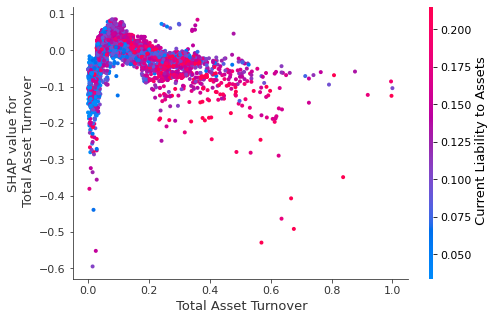

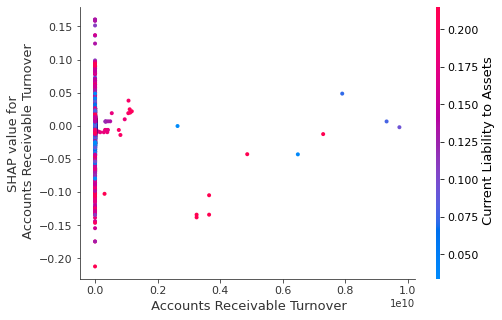

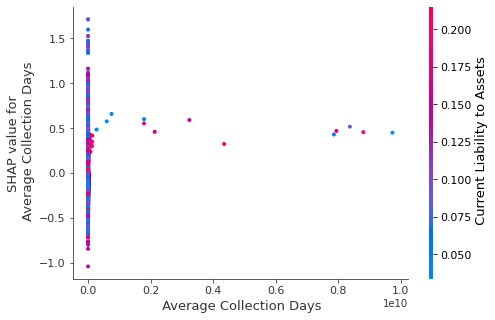

KeyboardInterrupt: 

In [28]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X_train)

Next, I'll explore the effect of features on the prediction of each record, such as the first one with index 0:

In [29]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_train.iloc[0,:])

How about the second record?

In [30]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], X_train.iloc[1,:])

The prediction of both records are lower than the base value, which means these two records were classified as "not bankrupt". Those features which push the prediction to the direction of "not bankrupt" are shown in blue.

<a id='conclusion'></a>
## Conclusion

The performance of the LightGBM model is pretty good, with accuracy 0.99 and F1-score 0.99. 

Using this model, investors would be able to assess the potential of companies based on the finance report in an efficient way.